In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import TreebankWordTokenizer
from nltk.stem import PorterStemmer
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.metrics.pairwise import cosine_similarity
import re
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

/opt/anaconda3/envs/anly521/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [6]:
resumes = pd.read_csv('resume.csv')

In [9]:
import pandas as pd
import glob
path = '/Users/adiamtesfaselassie/Documents/Spring2023/ANLY521/JobPosts/data/'

jobs = glob.glob(path + "/*.csv")
df_list = (pd.read_csv(file) for file in jobs)
jobs_df = pd.concat(df_list)
df = jobs_df.dropna(subset=['Job'])



In [10]:
%%time
def tokenize_stem(series):

    tokenizer =TreebankWordTokenizer()
    stemmer = PorterStemmer()
    series = series.apply(lambda x: tokenizer.tokenize(x))
    series = series.apply(lambda x: [stemmer.stem(w) for w in x])
    series = series.apply(lambda x: ' '.join(x))
    return series

def display_topics(model, feature_names, no_top_words, topic_names=None):
    topic_list = []
    for i, topic in enumerate(model.components_):
#         if not topic_names or not topic_names[i]:
#             print("\nTopic ", i)
#         else:
#             print("\nTopic: '",topic_names[i],"'")
        
#         print(", ".join([feature_names[k]
#                        for k in topic.argsort()[:-no_top_words - 1:-1]]))
        topic_list.append(", ".join([feature_names[k]
                       for k in topic.argsort()[:-no_top_words - 1:-1]]))
    return model.components_, topic_list


CPU times: user 12 µs, sys: 49 µs, total: 61 µs
Wall time: 69.9 µs


In [34]:
def return_topics(series, num_topics, no_top_words, model, vectorizer):
    #turn job into series
    series = tokenize_stem(series)
    #transform series into corpus
    ex_label = [e[:30]+"..." for e in series]
    #set vectorizer ngrams = (2,2)
    vec = vectorizer(stop_words = 'english')

    doc_word = vec.fit_transform(series)

    #build model
    def_model = model(num_topics)
    doc_topic = def_model.fit_transform(doc_word)
    print('model components: ', def_model.components_[0].shape)
    print('doc_topic', doc_topic[0])
    model_components, topic_list = display_topics(def_model, vec.get_feature_names_out(), no_top_words)
    return def_model.components_, doc_topic, def_model, vec, topic_list#, topics


In [35]:
def process_data():
    #read in jobs file and get descriptions
    #df = pd.read_csv('jobs.csv')
    #df = df[df.keyword!='marketing']
    jobs_df = pd.DataFrame(zip(df['Short Description'], df['Job']), columns = ['Description', 'Job'])

    array, doc, topic_model, vec, topic_list  = return_topics(jobs_df['Description'],20, 10, TruncatedSVD, TfidfVectorizer)
    doc.shape

    topic_df = pd.DataFrame(doc)
    topic_df.columns = ['Topic ' + str(i+1) for i in range(len(topic_df.columns)) ]

    topic_df['job'] = jobs_df.Job
    #Topic_DF.to_csv('topic_df.csv')
    return topic_df, topic_model, vec, topic_list

In [36]:
def predictive_modeling(df):
    '''
    fits, optimizes, and predicts job class based on topic modeling corpus
    '''
    X,y = df.iloc[:,0:-1], df.iloc[:, -1]
    X_tr, X_te, y_tr, y_te = train_test_split(X,y)

    param_grid = {'n_estimators': [100,300, 400, 500, 600], 'max_depth': [3,7,9, 11]}
    # search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
    # search.fit(X_tr, y_tr)
    # bp = search.best_params_
    # print(bp)
    #rfc = RandomForestClassifier(n_estimators = bp['n_estimators'], max_depth = bp['max_depth'])
    rfc = RandomForestClassifier(n_estimators = 500, max_depth = 9)
    rfc.fit(X_tr, y_tr)
    print('acc: ', np.mean(cross_val_score(rfc, X_tr, y_tr, scoring = 'accuracy', cv=5)))
    print('test_acc: ', accuracy_score(y_te, rfc.predict(X_te)))
    print(rfc.predict(X_te))
    return rfc

In [37]:
#start
def predict_resume(topic_model, model, resume):
    '''
    transforms a resume based on the topic modeling model and return prediction probabilities per each job class
    '''
    doc = topic_model.transform(resume)
    return model.predict_proba(doc), model.classes_, doc

In [38]:
def main():
    jobs_df, model, vec, topic_list = process_data()
    model_1 = predictive_modeling(jobs_df)
    
    for i,doc in enumerate(resumes.Resumes):
        doc = tokenize_stem(pd.Series(doc))
        doc = vec.transform(doc)
        #do cosine similarity compared to job 1 to job 100
        #this would spit out the specifc job application + 
        print(resumes.Person[i])
        print('----------------')
        probabilities, classes,doc1 = predict_resume(model, model_1, doc)
    print(doc)


In [39]:
import matplotlib.pyplot as plt

In [40]:
def create_clusters():
    topic_df, model, vec, topic_list = process_data()
    pca = PCA(n_components=2)
    X_train = topic_df.iloc[:, :-1]
    y_train = topic_df.iloc[:, -1]
    y_vals = y_train.unique()
    pca.fit(X_train)
    return X_train, pca.transform(X_train), y_train, y_vals, topic_list
     
from itertools import cycle

In [41]:
def plot_PCA_2D(data, target, target_names):
    colors = cycle(['r','g','b','c','m','y','orange','w','aqua','yellow'])
    target_ids = range(len(target_names))
    plt.figure(figsize=(10,10))
    for i, c, label in zip(target_ids, colors, target_names):
        plt.scatter(data[target == i, 0], data[target == i, 1],
                   c=c, label=label, edgecolors='gray')
    plt.title('Clustering Job Types')
    plt.xlabel('Marketing / Design Words')
    plt.ylabel('Management / Finance Words')
    plt.legend()

model components:  (985,)
doc_topic [ 0.07256927 -0.03087118 -0.06451645 -0.02750972 -0.00695822  0.07220269
 -0.04095398 -0.02645518  0.04420176  0.02266507 -0.00492545  0.01496224
 -0.01171713  0.00426872 -0.01975162  0.08086465 -0.01807825  0.07773789
 -0.00765317  0.02949665]


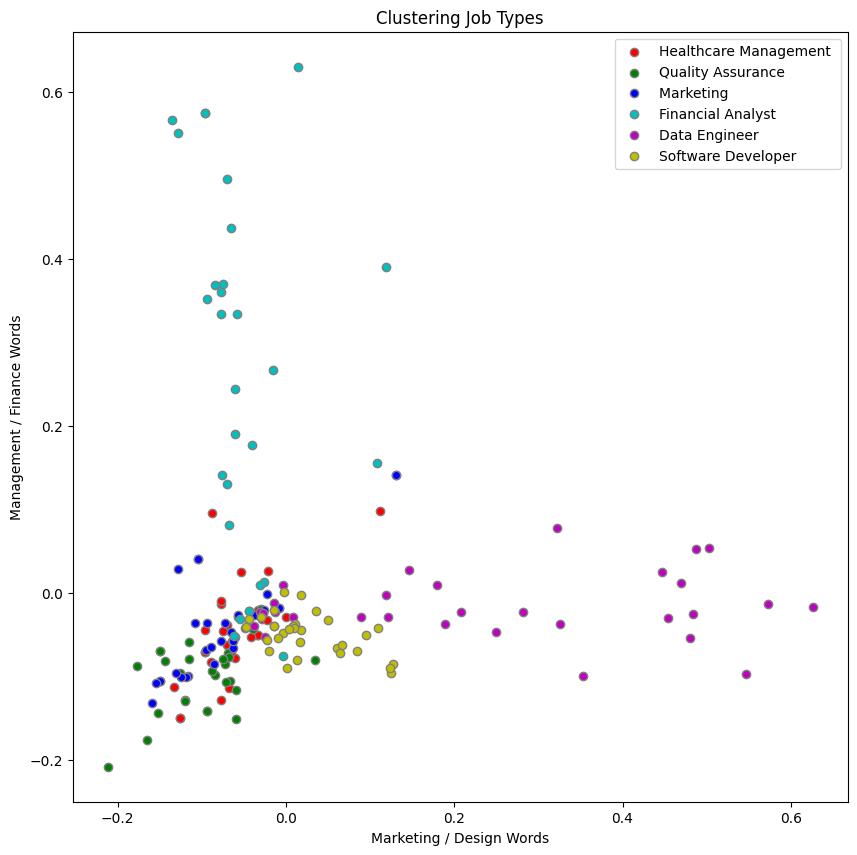

In [42]:
X_train, pca_train, y_train, y_vals, topic_list = create_clusters()

for i, val in enumerate(y_train.unique()):
    y_train = y_train.apply(lambda x: i if x == val else x)


plot_PCA_2D(pca_train, y_train, y_vals)